In [ ]:
!pip install lightfm scikit-learn pandas numpy


In [ ]:
import pandas as pd
import numpy as np
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k, auc_score
from lightfm.cross_validation import random_train_test_split
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Cell 2: Load and Explore Data
# Load the datasets
books_df = pd.read_csv('books.csv')
ratings_df = pd.read_csv('ratings.csv')

print("Books dataset shape:", books_df.shape)
print("Ratings dataset shape:", ratings_df.shape)
print("\nRatings distribution:")
print(ratings_df['rating'].value_counts().sort_index())
print(f"\nUnique users: {ratings_df['user_id'].nunique()}")
print(f"Unique books: {ratings_df['book_id'].nunique()}")

Books dataset shape: (10000, 23)
Ratings dataset shape: (5976479, 3)

Ratings distribution:
rating
1     124195
2     359257
3    1370916
4    2139018
5    1983093
Name: count, dtype: int64

Unique users: 53424
Unique books: 10000


In [ ]:
books_df = books_df.copy()
# Handle missing values
books_df['authors'] = books_df['authors'].fillna('Unknown')
books_df['original_publication_year'] = books_df['original_publication_year'].fillna(
    books_df['original_publication_year'].median()
)
books_df['language_code'] = books_df['language_code'].fillna('eng')
books_df['average_rating'] = books_df['average_rating'].fillna(
    books_df['average_rating'].mean()
)

# Create book features for LightFM
def create_book_features(books_df):
    features = []

    # Average rating buckets
    books_df['rating_bucket'] = pd.cut(books_df['average_rating'],
                                      bins=[0, 3.5, 4.0, 4.5, 5.0],
                                      labels=['low_rating', 'medium_rating', 'high_rating', 'excellent_rating'])

    # Publication year buckets
    books_df['year_bucket'] = pd.cut(books_df['original_publication_year'],
                                    bins=[0, 1950, 1980, 2000, 2010, 2025],
                                    labels=['classic', 'mid_century', 'modern', 'recent', 'contemporary'])

    # Popularity buckets based on ratings count
    books_df['popularity_bucket'] = pd.cut(books_df['ratings_count'],
                                          bins=[0, 100, 1000, 10000, float('inf')],
                                          labels=['niche', 'moderate', 'popular', 'bestseller'])

    # Create feature strings for each book
    for idx, row in books_df.iterrows():
        book_features = []

        # Add primary author (first author if multiple)
        primary_author = row['authors'].split(',')[0].strip()
        book_features.append(f"author:{primary_author.replace(' ', '_')}")

        # Add language
        book_features.append(f"language:{row['language_code']}")

        # Add rating bucket
        if pd.notna(row['rating_bucket']):
            book_features.append(f"rating:{row['rating_bucket']}")

        # Add year bucket
        if pd.notna(row['year_bucket']):
            book_features.append(f"year:{row['year_bucket']}")

        # Add popularity bucket
        if pd.notna(row['popularity_bucket']):
            book_features.append(f"popularity:{row['popularity_bucket']}")

        features.append(book_features)

    return features

book_features = create_book_features(books_df)
print("Sample book features:", book_features[0])


Sample book features: ['author:Suzanne_Collins', 'language:eng', 'rating:high_rating', 'year:recent', 'popularity:bestseller']


In [ ]:
# Cell 4: Create Interaction Matrix with Hybrid Feedback
def create_interaction_data(ratings_df):
    """
    Create interaction matrix with hybrid feedback:
    - Binary implicit feedback (rating >= 4 = 1, else 0)
    - Rating confidence weights (higher ratings get higher weights)
    """

    # Create binary implicit feedback (rating >= 4 means positive interaction)
    ratings_df['implicit_feedback'] = (ratings_df['rating'] >= 4).astype(int)

    # Create confidence weights (rating value normalized)
    ratings_df['confidence'] = ratings_df['rating'] / 5.0

    return ratings_df

# Process ratings data
processed_ratings = create_interaction_data(ratings_df)

print("Processed ratings sample:")
print(processed_ratings[['user_id', 'book_id', 'rating', 'implicit_feedback', 'confidence']].head())
print(f"\nPositive interactions (rating >= 4): {processed_ratings['implicit_feedback'].sum()}")
print(f"Total interactions: {len(processed_ratings)}")


Processed ratings sample:
   user_id  book_id  rating  implicit_feedback  confidence
0        1      258       5                  1         1.0
1        2     4081       4                  1         0.8
2        2      260       5                  1         1.0
3        2     9296       5                  1         1.0
4        2     2318       3                  0         0.6

Positive interactions (rating >= 4): 4122111
Total interactions: 5976479


In [ ]:
# Cell 5: Build LightFM Dataset
# Create LightFM dataset
dataset = Dataset()

# Fit the dataset with users, items, and item features
dataset.fit(
    users=processed_ratings['user_id'].unique(),
    items=processed_ratings['book_id'].unique(),
    item_features=[feature for features in book_features for feature in features]
)

print(f"Dataset built with:")
print(f"- Users: {len(processed_ratings['user_id'].unique())}")
print(f"- Items: {len(processed_ratings['book_id'].unique())}")
print(f"- Item features: {len([feature for features in book_features for feature in features])}")

# Build interactions matrix
(interactions, weights) = dataset.build_interactions(
    [(row['user_id'], row['book_id'], row['confidence'])
     for _, row in processed_ratings[processed_ratings['implicit_feedback'] == 1].iterrows()]
)

# Build item features matrix
item_features_matrix = dataset.build_item_features(
    [(book_id, features) for book_id, features in
     zip(books_df['book_id'], book_features)]
)

print(f"Interactions matrix shape: {interactions.shape}")
print(f"Item features matrix shape: {item_features_matrix.shape}")

Dataset built with:
- Users: 53424
- Items: 10000
- Item features: 49969
Interactions matrix shape: (53424, 10000)
Item features matrix shape: (10000, 13924)


In [ ]:
# Cell 6: Train-Test Split and Model Training
# Split data for evaluation
train_interactions, test_interactions = random_train_test_split(
    interactions, test_percentage=0.2, random_state=42
)

train_weights, test_weights = random_train_test_split(
    weights, test_percentage=0.2, random_state=42
)

print(f"Train interactions: {train_interactions.nnz}")
print(f"Test interactions: {test_interactions.nnz}")

# Initialize and train LightFM model
model = LightFM(
    loss='warp',  # Good for implicit feedback with ranking
    learning_rate=0.05,
    item_alpha=1e-6,
    user_alpha=1e-6,
    random_state=42,
    no_components=50
)

# Train the model
print("Training LightFM model...")
model.fit(
    interactions=train_interactions,
    sample_weight=train_weights,
    item_features=item_features_matrix,
    epochs=30,
    num_threads=4,
    verbose=True
)

print("Model training completed!")


Train interactions: 3297688
Test interactions: 824423
Training LightFM model...


Epoch: 100%|██████████| 30/30 [12:34<00:00, 25.14s/it]

Model training completed!


In [ ]:
# Cell 7: Model Evaluation
# Evaluate model performance
train_precision = precision_at_k(model, train_interactions, k=10,
                                item_features=item_features_matrix).mean()
test_precision = precision_at_k(model, test_interactions, k=10,
                               item_features=item_features_matrix,
                               train_interactions=train_interactions).mean()

train_auc = auc_score(model, train_interactions,
                     item_features=item_features_matrix).mean()
test_auc = auc_score(model, test_interactions,
                    item_features=item_features_matrix,
                    train_interactions=train_interactions).mean()

print("Model Performance:")
print(f"Train Precision@10: {train_precision:.4f}")
print(f"Test Precision@10: {test_precision:.4f}")
print(f"Train AUC: {train_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")


Model Performance:
Train Precision@10: 0.4426
Test Precision@10: 0.1825
Train AUC: 0.9699
Test AUC: 0.9565


In [ ]:
# Cell 8: Recommendation Functions
def get_book_title(book_id, books_df):
    """Get book title from book_id"""
    book_info = books_df[books_df['book_id'] == book_id]
    if not book_info.empty:
        return book_info.iloc[0]['title']
    return f"Book ID: {book_id}"

def get_recommendations(model, user_id, dataset, books_df,
                       interactions_matrix=None, item_features=None,
                       n_recommendations=10):
    """
    Get top N book recommendations for a user
    """

    # Get user and item mappings
    user_id_map, user_features_map, item_id_map, item_features_map = dataset.mapping()

    # Check if user exists in the dataset
    if user_id not in user_id_map:
        print(f"User {user_id} not found in dataset")
        return []

    # Get internal user ID
    user_x = user_id_map[user_id]

    # Get all item IDs
    n_items = len(item_id_map)
    item_ids = list(item_id_map.keys())

    # Predict scores for all items
    scores = model.predict(
        user_ids=user_x,
        item_ids=list(range(n_items)),
        item_features=item_features
    )

    # Get items user has already interacted with (to exclude them)
    known_items = set()
    if interactions_matrix is not None:
        # Convert to CSR format for efficient row access
        interactions_csr = interactions_matrix.tocsr()
        known_items = set(interactions_csr[user_x].indices)

    # Create list of (score, item_id) for items user hasn't seen
    recommendations = []
    for internal_item_id, score in enumerate(scores):
        if internal_item_id not in known_items:
            # Map back to original item ID
            original_item_id = item_ids[internal_item_id]
            recommendations.append((score, original_item_id))

    # Sort by score and get top N
    recommendations.sort(reverse=True)
    top_recommendations = recommendations[:n_recommendations]

    # Format results with book titles
    result = []
    for score, book_id in top_recommendations:
        title = get_book_title(book_id, books_df)
        book_info = books_df[books_df['book_id'] == book_id]
        if not book_info.empty:
            author = book_info.iloc[0]['authors']
            avg_rating = book_info.iloc[0]['average_rating']
            result.append({
                'book_id': book_id,
                'title': title,
                'author': author,
                'average_rating': avg_rating,
                'prediction_score': score
            })

    return result

def display_recommendations(recommendations):
    """Display recommendations in a nice format"""
    print("=" * 80)
    print("TOP 10 BOOK RECOMMENDATIONS")
    print("=" * 80)

    for i, rec in enumerate(recommendations, 1):
        print(f"{i:2d}. {rec['title']}")
        print(f"    Author: {rec['author']}")
        print(f"    Average Rating: {rec['average_rating']:.2f}")
        print(f"    Prediction Score: {rec['prediction_score']:.4f}")
        print(f"    Book ID: {rec['book_id']}")
        print()

In [ ]:
# Cell 9: Generate Sample Recommendations
# Get a sample user who has rated books
sample_user_id = processed_ratings['user_id'].value_counts().index[0]  # User with most ratings
print(f"Generating recommendations for User ID: {sample_user_id}")

# Show user's rating history
user_history = processed_ratings[processed_ratings['user_id'] == sample_user_id].merge(
    books_df[['book_id', 'title', 'authors']], on='book_id'
)

print(f"\nUser {sample_user_id}'s Reading History (last 10 books):")
print("-" * 60)
for _, row in user_history.tail(10).iterrows():
    print(f"Rating {row['rating']}: {row['title']} by {row['authors']}")

# Generate recommendations
recommendations = get_recommendations(
    model=model,
    user_id=sample_user_id,
    dataset=dataset,
    books_df=books_df,
    interactions_matrix=train_interactions,
    item_features=item_features_matrix,
    n_recommendations=10
)

# Display recommendations
print(f"\n")
display_recommendations(recommendations)

Generating recommendations for User ID: 30944

User 30944's Reading History (last 10 books):
------------------------------------------------------------
Rating 5: Alexander and the Terrible, Horrible, No Good, Very Bad Day by Judith Viorst, Ray Cruz
Rating 3: Inkspell (Inkworld, #2) by Cornelia Funke, Anthea Bell
Rating 4: Bone Crossed (Mercy Thompson, #4) by Patricia Briggs
Rating 5: Mort (Death, #1; Discworld, #4) by Terry Pratchett
Rating 5: The Shadow Rising (Wheel of Time, #4) by Robert Jordan
Rating 5: Maus I: A Survivor's Tale: My Father Bleeds History (Maus, #1) by Art Spiegelman
Rating 3: The Sword of Shannara (The Original Shannara Trilogy, #1) by Terry Brooks
Rating 4: Blood Bound (Mercy Thompson, #2) by Patricia Briggs
Rating 5: Wizard and Glass (The Dark Tower, #4) by Stephen King, Dave McKean
Rating 5: Let the Right One In by John Ajvide Lindqvist


TOP 10 BOOK RECOMMENDATIONS
 1. Harry Potter and the Half-Blood Prince (Harry Potter, #6)
    Author: J.K. Rowling, Mary Gr

In [ ]:
# Cell 10: Book Similarity Recommendation Function
def get_similar_books(model, book_id, dataset, books_df, n_recommendations=10):
    """
    Get top N books similar to a given book based on item embeddings
    """
    from sklearn.metrics.pairwise import cosine_similarity

    # Get mappings
    user_id_map, user_features_map, item_id_map, item_features_map = dataset.mapping()

    # Check if book exists in the dataset
    if book_id not in item_id_map:
        print(f"Book ID {book_id} not found in dataset")
        return []

    # Get internal item ID
    item_x = item_id_map[book_id]

    # Get item embeddings from the model
    item_embeddings = model.item_embeddings
    n_items_in_model = item_embeddings.shape[0]

    # Create reverse mapping from internal ID to original book ID
    reverse_item_map = {v: k for k, v in item_id_map.items()}

    # Calculate cosine similarity between target book and all other books
    target_embedding = item_embeddings[item_x].reshape(1, -1)
    similarities = cosine_similarity(target_embedding, item_embeddings)[0]

    # Create list of (similarity, book_id) excluding the target book itself
    similar_books = []
    for internal_item_id, similarity in enumerate(similarities):
        if internal_item_id != item_x and internal_item_id in reverse_item_map:
            original_book_id = reverse_item_map[internal_item_id]
            similar_books.append((similarity, original_book_id))

    # Sort by similarity and get top N
    similar_books.sort(reverse=True)
    top_similar = similar_books[:n_recommendations]

    # Format results with book information
    result = []
    for similarity, similar_book_id in top_similar:
        title = get_book_title(similar_book_id, books_df)
        book_info = books_df[books_df['book_id'] == similar_book_id]
        if not book_info.empty:
            author = book_info.iloc[0]['authors']
            avg_rating = book_info.iloc[0]['average_rating']
            result.append({
                'book_id': similar_book_id,
                'title': title,
                'author': author,
                'average_rating': avg_rating,
                'similarity_score': similarity
            })

    return result

def display_similar_books(target_book_id, books_df, similar_books):
    """Display similar books in a nice format"""

    # Get target book info
    target_book_info = books_df[books_df['book_id'] == target_book_id]
    if not target_book_info.empty:
        target_title = target_book_info.iloc[0]['title']
        target_author = target_book_info.iloc[0]['authors']
        target_rating = target_book_info.iloc[0]['average_rating']
    else:
        target_title = f"Book ID: {target_book_id}"
        target_author = "Unknown"
        target_rating = "N/A"

    print("=" * 80)
    print(f"BOOKS SIMILAR TO: {target_title}")
    print(f"Author: {target_author} | Rating: {target_rating}")
    print("=" * 80)

    for i, book in enumerate(similar_books, 1):
        print(f"{i:2d}. {book['title']}")
        print(f"    Author: {book['author']}")
        print(f"    Average Rating: {book['average_rating']:.2f}")
        print(f"    Similarity Score: {book['similarity_score']:.4f}")
        print(f"    Book ID: {book['book_id']}")
        print()

def recommend_similar_books(book_id, n_recommendations=10):
    """
    Easy-to-use function to get books similar to a given book
    """
    similar_books = get_similar_books(
        model=model,
        book_id=book_id,
        dataset=dataset,
        books_df=books_df,
        n_recommendations=n_recommendations
    )

    if similar_books:
        display_similar_books(book_id, books_df, similar_books)

        # Return as DataFrame for easy manipulation
        return pd.DataFrame(similar_books)
    else:
        print(f"No similar books found for Book ID {book_id}")
        return pd.DataFrame()

In [ ]:
# Cell 10b: Interactive Recommendation Function
def recommend_books_for_user(user_id, n_recommendations=10):
    """
    Easy-to-use function to get recommendations for any user
    """
    recommendations = get_recommendations(
        model=model,
        user_id=user_id,
        dataset=dataset,
        books_df=books_df,
        interactions_matrix=train_interactions,
        item_features=item_features_matrix,
        n_recommendations=n_recommendations
    )

    if recommendations:
        print(f"Top {n_recommendations} Recommendations for User {user_id}:")
        display_recommendations(recommendations)

        # Return as DataFrame for easy manipulation
        return pd.DataFrame(recommendations)
    else:
        print(f"No recommendations available for User {user_id}")
        return pd.DataFrame()

# Example usage:
# recommendations_df = recommend_books_for_user(user_id=1, n_recommendations=10)

print("\n" + "="*80)
print("RECOMMENDATION SYSTEM READY!")
print("="*80)
print("Use: recommend_books_for_user(user_id=YOUR_USER_ID, n_recommendations=10)")
print("Example: recommend_books_for_user(user_id=1, n_recommendations=5)")


RECOMMENDATION SYSTEM READY!
Use: recommend_books_for_user(user_id=YOUR_USER_ID, n_recommendations=10)
Example: recommend_books_for_user(user_id=1, n_recommendations=5)


In [ ]:
# Cell 11: Example Usage and Testing
# Test book similarity recommendations with a popular book
sample_book_id = ratings_df['book_id'].value_counts().index[0]  # Most rated book
print(f"Finding books similar to Book ID: {sample_book_id}")

# Show the target book info
target_book_info = books_df[books_df['book_id'] == sample_book_id]
if not target_book_info.empty:
    print(f"Target Book: {target_book_info.iloc[0]['title']}")
    print(f"Author: {target_book_info.iloc[0]['authors']}")
    print(f"Average Rating: {target_book_info.iloc[0]['average_rating']:.2f}")
    print(f"Total Ratings: {target_book_info.iloc[0]['ratings_count']}")

# Generate similar book recommendations
similar_books_df = recommend_similar_books(book_id=sample_book_id, n_recommendations=10)

print("\n" + "="*80)
print("BOTH RECOMMENDATION SYSTEMS READY!")
print("="*80)
print("For USER-based recommendations:")
print("  recommend_books_for_user(user_id=YOUR_USER_ID, n_recommendations=10)")
print("  Example: recommend_books_for_user(user_id=1, n_recommendations=5)")
print("\nFor BOOK-based similarity recommendations:")
print("  recommend_similar_books(book_id=YOUR_BOOK_ID, n_recommendations=10)")
print("  Example: recommend_similar_books(book_id=1, n_recommendations=5)")

Finding books similar to Book ID: 1
Target Book: The Hunger Games (The Hunger Games, #1)
Author: Suzanne Collins
Average Rating: 4.34
Total Ratings: 4780653
BOOKS SIMILAR TO: The Hunger Games (The Hunger Games, #1)
Author: Suzanne Collins | Rating: 4.34
 1. Water for Elephants
    Author: Sara Gruen
    Average Rating: 4.07
    Similarity Score: 0.9037
    Book ID: 46

 2. The Lovely Bones
    Author: Alice Sebold
    Average Rating: 3.77
    Similarity Score: 0.8743
    Book ID: 22

 3. The Great Gatsby
    Author: F. Scott Fitzgerald
    Average Rating: 3.89
    Similarity Score: 0.8709
    Book ID: 5

 4. The Time Traveler's Wife
    Author: Audrey Niffenegger
    Average Rating: 3.95
    Similarity Score: 0.8524
    Book ID: 38

 5. Divergent (Divergent, #1)
    Author: Veronica Roth
    Average Rating: 4.24
    Similarity Score: 0.8461
    Book ID: 12

 6. The Girl with the Dragon Tattoo (Millennium, #1)
    Author: Stieg Larsson, Reg Keeland
    Average Rating: 4.11
    Similarit

In [ ]:
recommend_similar_books(book_id=11, n_recommendations=10)

BOOKS SIMILAR TO: The Kite Runner
Author: Khaled Hosseini | Rating: 4.26
 1. Life of Pi
    Author: Yann Martel
    Average Rating: 3.88
    Similarity Score: 0.9192
    Book ID: 45

 2. A Thousand Splendid Suns
    Author: Khaled Hosseini
    Average Rating: 4.34
    Similarity Score: 0.8726
    Book ID: 67

 3. My Sister's Keeper
    Author: Jodi Picoult
    Average Rating: 4.06
    Similarity Score: 0.8715
    Book ID: 64

 4. The Curious Incident of the Dog in the Night-Time
    Author: Mark Haddon
    Average Rating: 3.85
    Similarity Score: 0.8419
    Book ID: 60

 5. The Fault in Our Stars
    Author: John Green
    Average Rating: 4.26
    Similarity Score: 0.8357
    Book ID: 6

 6. The Girl with the Dragon Tattoo (Millennium, #1)
    Author: Stieg Larsson, Reg Keeland
    Average Rating: 4.11
    Similarity Score: 0.8354
    Book ID: 16

 7. The Diary of a Young Girl
    Author: Anne Frank, Eleanor Roosevelt, B.M. Mooyaart-Doubleday
    Average Rating: 4.10
    Similarity S

,book_id,title,author,average_rating,similarity_score
0,45,Life of Pi,Yann Martel,3.88,0.919239
1,67,A Thousand Splendid Suns,Khaled Hosseini,4.34,0.872612
2,64,My Sister's Keeper,Jodi Picoult,4.06,0.871458
3,60,The Curious Incident of the Dog in the Night-Time,Mark Haddon,3.85,0.841905
4,6,The Fault in Our Stars,John Green,4.26,0.835673
5,16,"The Girl with the Dragon Tattoo (Millennium, #1)","Stieg Larsson, Reg Keeland",4.11,0.835351
6,15,The Diary of a Young Girl,"Anne Frank, Eleanor Roosevelt, B.M. Mooyaart-D...",4.10,0.834830
7,212,Atonement,Ian McEwan,3.88,0.825672
8,38,The Time Traveler's Wife,Audrey Niffenegger,3.95,0.825200
9,46,Water for Elephants,Sara Gruen,4.07,0.821082


In [ ]:
#write your user id
recommend_books_for_user(user_id=1, n_recommendations=10)

Top 10 Recommendations for User 1:
TOP 10 BOOK RECOMMENDATIONS
 1. The Kite Runner
    Author: Khaled Hosseini
    Average Rating: 4.26
    Prediction Score: 1.7301
    Book ID: 11

 2. The Great Gatsby
    Author: F. Scott Fitzgerald
    Average Rating: 3.89
    Prediction Score: 1.6871
    Book ID: 5

 3. Anna Karenina
    Author: Leo Tolstoy, Louise Maude, Leo Tolstoj, Aylmer Maude
    Average Rating: 4.02
    Prediction Score: 1.5117
    Book ID: 172

 4. All the Light We Cannot See
    Author: Anthony Doerr
    Average Rating: 4.31
    Prediction Score: 1.3485
    Book ID: 143

 5. The Book Thief
    Author: Markus Zusak
    Average Rating: 4.36
    Prediction Score: 1.3407
    Book ID: 47

 6. A Thousand Splendid Suns
    Author: Khaled Hosseini
    Average Rating: 4.34
    Prediction Score: 1.3405
    Book ID: 67

 7. The Diary of a Young Girl
    Author: Anne Frank, Eleanor Roosevelt, B.M. Mooyaart-Doubleday
    Average Rating: 4.10
    Prediction Score: 1.2904
    Book ID: 15


,book_id,title,author,average_rating,prediction_score
0,11,The Kite Runner,Khaled Hosseini,4.26,1.730096
1,5,The Great Gatsby,F. Scott Fitzgerald,3.89,1.687062
2,172,Anna Karenina,"Leo Tolstoy, Louise Maude, Leo Tolstoj, Aylmer...",4.02,1.511696
3,143,All the Light We Cannot See,Anthony Doerr,4.31,1.348517
4,47,The Book Thief,Markus Zusak,4.36,1.340669
5,67,A Thousand Splendid Suns,Khaled Hosseini,4.34,1.340532
6,15,The Diary of a Young Girl,"Anne Frank, Eleanor Roosevelt, B.M. Mooyaart-D...",4.10,1.290437
7,94,One Hundred Years of Solitude,"Gabriel García Márquez, Gregory Rabassa",4.04,1.250485
8,14,Animal Farm,George Orwell,3.87,1.201916
9,8,The Catcher in the Rye,J.D. Salinger,3.79,1.186409


In [ ]:
# Cell 11: Model Analysis and Feature Importance
def analyze_model_features(model, dataset, top_n=20):
    """Analyze which features are most important in the model"""

    # Get feature mappings
    _, _, _, item_features_map = dataset.mapping()

    # Get item feature weights (biases)
    item_biases = model.item_biases
    item_embeddings = model.item_embeddings

    print("Top Item Features by Average Embedding Magnitude:")
    print("-" * 60)

    # Calculate average magnitude for each feature
    feature_importance = {}
    for feature_name, feature_id in item_features_map.items():
        if feature_id < len(item_biases):
            # Calculate importance as combination of bias and embedding magnitude
            embedding_mag = np.linalg.norm(item_embeddings[feature_id])
            bias_mag = abs(item_biases[feature_id])
            importance = embedding_mag + bias_mag
            feature_importance[feature_name] = importance

    # Sort and display top features
    sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

    for i, (feature, importance) in enumerate(sorted_features[:top_n]):
        print(f"{i+1:2d}. {feature}: {importance:.4f}")

analyze_model_features(model, dataset, top_n=20)

Top Item Features by Average Embedding Magnitude:
------------------------------------------------------------
 1. author:Terry_Pratchett: 23.2914
 2. author:J.D._Robb: 22.2079
 3. author:Nora_Roberts: 22.2043
 4. author:James_Patterson: 21.9261
 5. author:Laurell_K._Hamilton: 21.4724
 6. author:Janet_Evanovich: 21.2244
 7. author:Stephen_King: 20.8540
 8. author:Tamora_Pierce: 20.5660
 9. author:Dean_Koontz: 20.2168
10. author:J.K._Rowling: 19.9477
11. author:Jim_Butcher: 19.8045
12. author:Sherrilyn_Kenyon: 18.6209
13. author:R.A._Salvatore: 18.3928
14. language:ara: 18.2076
15. author:John_Grisham: 18.1976
16. author:John_Sandford: 18.1020
17. author:David_Eddings: 18.0217
18. author:Sue_Grafton: 17.9080
19. author:Michael_Connelly: 17.8451
20. author:Charlaine_Harris: 17.6712


In [ ]:
# Cell 12: Model Analysis and Feature Importance
def analyze_model_features(model, dataset, top_n=20):
    """Analyze which features are most important in the model"""

    # Get feature mappings
    _, _, _, item_features_map = dataset.mapping()

    # Get item feature weights (biases)
    item_biases = model.item_biases
    item_embeddings = model.item_embeddings

    print("Top Item Features by Average Embedding Magnitude:")
    print("-" * 60)

    # Calculate average magnitude for each feature
    feature_importance = {}
    for feature_name, feature_id in item_features_map.items():
        if feature_id < len(item_biases):
            # Calculate importance as combination of bias and embedding magnitude
            embedding_mag = np.linalg.norm(item_embeddings[feature_id])
            bias_mag = abs(item_biases[feature_id])
            importance = embedding_mag + bias_mag
            feature_importance[feature_name] = importance

    # Sort and display top features
    sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

    for i, (feature, importance) in enumerate(sorted_features[:top_n]):
        print(f"{i+1:2d}. {feature}: {importance:.4f}")

analyze_model_features(model, dataset, top_n=20)

# Cell 13: Save Model and Dataset (Optional)
import pickle

# Save the trained model and dataset for later use
def save_model_and_data():
    """Save the trained model and necessary data structures"""

    model_data = {
        'model': model,
        'dataset': dataset,
        'books_df': books_df,
        'item_features_matrix': item_features_matrix,
        'train_interactions': train_interactions
    }

    with open('lightfm_book_recommender.pkl', 'wb') as f:
        pickle.dump(model_data, f)

    print("Model and data saved to 'lightfm_book_recommender.pkl'")

def load_model_and_data():
    """Load the saved model and data structures"""

    with open('lightfm_book_recommender.pkl', 'rb') as f:
        model_data = pickle.load(f)

    return (model_data['model'], model_data['dataset'],
            model_data['books_df'], model_data['item_features_matrix'],
            model_data['train_interactions'])

# Uncomment to save:
# save_model_and_data()

print("\n" + "="*80)
print("LIGHTFM BOOK RECOMMENDER SYSTEM COMPLETE!")
print("="*80)
print("Features implemented:")
print("✓ Hybrid feedback (implicit + confidence weights)")
print("✓ Rich item features (author, language, rating, year, popularity)")
print("✓ WARP loss for ranking optimization")
print("✓ Train/test evaluation")
print("✓ Easy-to-use recommendation function")
print("✓ Model analysis and feature importance")
print("✓ Save/load functionality")

Top Item Features by Average Embedding Magnitude:
------------------------------------------------------------
 1. author:Terry_Pratchett: 23.2914
 2. author:J.D._Robb: 22.2079
 3. author:Nora_Roberts: 22.2043
 4. author:James_Patterson: 21.9261
 5. author:Laurell_K._Hamilton: 21.4724
 6. author:Janet_Evanovich: 21.2244
 7. author:Stephen_King: 20.8540
 8. author:Tamora_Pierce: 20.5660
 9. author:Dean_Koontz: 20.2168
10. author:J.K._Rowling: 19.9477
11. author:Jim_Butcher: 19.8045
12. author:Sherrilyn_Kenyon: 18.6209
13. author:R.A._Salvatore: 18.3928
14. language:ara: 18.2076
15. author:John_Grisham: 18.1976
16. author:John_Sandford: 18.1020
17. author:David_Eddings: 18.0217
18. author:Sue_Grafton: 17.9080
19. author:Michael_Connelly: 17.8451
20. author:Charlaine_Harris: 17.6712

LIGHTFM BOOK RECOMMENDER SYSTEM COMPLETE!
Features implemented:
✓ Hybrid feedback (implicit + confidence weights)
✓ Rich item features (author, language, rating, year, popularity)
✓ WARP loss for ranking opti

In [ ]:
import numpy as np
import pandas as pd
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

def get_positives_lookup_dict(interactions):
    """
    Create a lookup dictionary of positive items for each user
    """
    positives_lookup = {}
    interactions_coo = interactions.tocoo()

    for user_id, item_id in zip(interactions_coo.row, interactions_coo.col):
        if user_id not in positives_lookup:
            positives_lookup[user_id] = []
        positives_lookup[user_id].append(item_id)

    return positives_lookup

def ndcg_at_k(model, test_interactions, train_interactions=None, k=10,
              user_features=None, item_features=None, preserve_rows=False,
              num_threads=1, check_intersections=True):
    """
    Calculate NDCG@k for LightFM model
    """
    if train_interactions is None:
        train_interactions = test_interactions

    # Get positive items for each user
    positives_lookup = get_positives_lookup_dict(test_interactions)

    ndcg_scores = []

    for user_id in range(test_interactions.shape[0]):
        if user_id not in positives_lookup:
            continue

        # Get predictions for all items for this user
        scores = model.predict(
            user_ids=user_id,
            item_ids=np.arange(test_interactions.shape[1]),
            user_features=user_features,
            item_features=item_features,
            num_threads=num_threads
        )

        # Get top k predictions
        top_k_items = np.argsort(-scores)[:k]

        # Calculate DCG
        dcg = 0.0
        positive_items = set(positives_lookup[user_id])

        for i, item in enumerate(top_k_items):
            if item in positive_items:
                dcg += 1.0 / np.log2(i + 2)  # +2 because log2(1) = 0

        # Calculate IDCG (best possible DCG)
        num_positives = min(len(positive_items), k)
        idcg = sum(1.0 / np.log2(i + 2) for i in range(num_positives))

        # Calculate NDCG
        if idcg > 0:
            ndcg = dcg / idcg
        else:
            ndcg = 0.0

        ndcg_scores.append(ndcg)

    return np.mean(ndcg_scores) if ndcg_scores else 0.0

def evaluate_model_comprehensive(model, train_interactions, test_interactions,
                               item_features_matrix=None, k_values=None):
    """
    Comprehensive evaluation of LightFM model with multiple metrics
    """
    if k_values is None:
        k_values = list(range(1, 21))  # k from 1 to 20

    print("Starting comprehensive model evaluation...")
    print(f"Evaluating for k values: {k_values}")

    results = []

    # Calculate AUC (doesn't depend on k)
    print("Calculating AUC...")
    try:
        auc = auc_score(
            model,
            test_interactions,
            train_interactions=train_interactions,
            item_features=item_features_matrix,
            num_threads=4
        ).mean()
    except Exception as e:
        print(f"Error calculating AUC: {e}")
        auc = np.nan

    # Calculate metrics for each k value
    for k in k_values:
        print(f"Calculating metrics for k={k}...")

        try:
            # Precision@k
            precision = precision_at_k(
                model,
                test_interactions,
                train_interactions=train_interactions,
                k=k,
                item_features=item_features_matrix,
                num_threads=4
            ).mean()
        except Exception as e:
            print(f"Error calculating Precision@{k}: {e}")
            precision = np.nan

        try:
            # Recall@k
            recall = recall_at_k(
                model,
                test_interactions,
                train_interactions=train_interactions,
                k=k,
                item_features=item_features_matrix,
                num_threads=4
            ).mean()
        except Exception as e:
            print(f"Error calculating Recall@{k}: {e}")
            recall = np.nan

        try:
            # NDCG@k
            ndcg = ndcg_at_k(
                model,
                test_interactions,
                train_interactions=train_interactions,
                k=k,
                item_features=item_features_matrix,
                num_threads=4
            )
        except Exception as e:
            print(f"Error calculating NDCG@{k}: {e}")
            ndcg = np.nan

        # Store results
        results.append({
            'k': k,
            'precision_at_k': precision,
            'recall_at_k': recall,
            'ndcg_at_k': ndcg,
            'auc': auc  # Same for all k values
        })

        print(f"k={k}: Precision={precision:.4f}, Recall={recall:.4f}, NDCG={ndcg:.4f}")

    return results

# Run the evaluation
print("="*50)
print("LIGHTFM MODEL EVALUATION")
print("="*50)

# Evaluate the model
evaluation_results = evaluate_model_comprehensive(
    model=model,
    train_interactions=train_interactions,
    test_interactions=test_interactions,
    item_features_matrix=item_features_matrix,
    k_values=list(range(1, 21))
)

# Convert to DataFrame
results_df = pd.DataFrame(evaluation_results)

# Display results
print("\n" + "="*60)
print("EVALUATION RESULTS SUMMARY")
print("="*60)
print(results_df.round(4))

# Calculate some summary statistics
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)
print(f"AUC Score: {results_df['auc'].iloc[0]:.4f}")
print(f"Best Precision@k: {results_df['precision_at_k'].max():.4f} at k={results_df.loc[results_df['precision_at_k'].idxmax(), 'k']}")
print(f"Best Recall@k: {results_df['recall_at_k'].max():.4f} at k={results_df.loc[results_df['recall_at_k'].idxmax(), 'k']}")
print(f"Best NDCG@k: {results_df['ndcg_at_k'].max():.4f} at k={results_df.loc[results_df['ndcg_at_k'].idxmax(), 'k']}")

# Save to CSV
csv_filename = 'lightfm_evaluation_results.csv'
results_df.to_csv(csv_filename, index=False)
print(f"\nResults saved to: {csv_filename}")

# Create a more detailed summary
summary_stats = {
    'Metric': ['AUC', 'Precision@10', 'Recall@10', 'NDCG@10', 'Precision@5', 'Recall@5', 'NDCG@5'],
    'Value': [
        results_df['auc'].iloc[0],
        results_df[results_df['k'] == 10]['precision_at_k'].iloc[0],
        results_df[results_df['k'] == 10]['recall_at_k'].iloc[0],
        results_df[results_df['k'] == 10]['ndcg_at_k'].iloc[0],
        results_df[results_df['k'] == 5]['precision_at_k'].iloc[0],
        results_df[results_df['k'] == 5]['recall_at_k'].iloc[0],
        results_df[results_df['k'] == 5]['ndcg_at_k'].iloc[0]
    ]
}

summary_df = pd.DataFrame(summary_stats)
print("\n" + "="*40)
print("KEY METRICS SUMMARY")
print("="*40)
print(summary_df.round(4))

# Save summary to separate CSV
summary_filename = 'lightfm_evaluation_summary.csv'
summary_df.to_csv(summary_filename, index=False)
print(f"\nSummary saved to: {summary_filename}")

print("\nEvaluation completed successfully!")
print(f"Full results: {csv_filename}")
print(f"Summary: {summary_filename}")

LIGHTFM MODEL EVALUATION
Starting comprehensive model evaluation...
Evaluating for k values: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Calculating AUC...
Calculating metrics for k=1...
k=1: Precision=0.2807, Recall=0.0191, NDCG=0.1134
Calculating metrics for k=2...
k=2: Precision=0.2579, Recall=0.0349, NDCG=0.1120
Calculating metrics for k=3...
k=3: Precision=0.2414, Recall=0.0488, NDCG=0.1113
Calculating metrics for k=4...
k=4: Precision=0.2277, Recall=0.0611, NDCG=0.1103
Calculating metrics for k=5...
k=5: Precision=0.2168, Recall=0.0725, NDCG=0.1092
Calculating metrics for k=6...
k=6: Precision=0.2079, Recall=0.0832, NDCG=0.1083
Calculating metrics for k=7...
k=7: Precision=0.2004, Recall=0.0933, NDCG=0.1077
Calculating metrics for k=8...
k=8: Precision=0.1941, Recall=0.1030, NDCG=0.1072
Calculating metrics for k=9...
k=9: Precision=0.1881, Recall=0.1121, NDCG=0.1070
Calculating metrics for k=10...
k=10: Precision=0.1825, Recall=0.1207, NDCG=0.1069
Calc

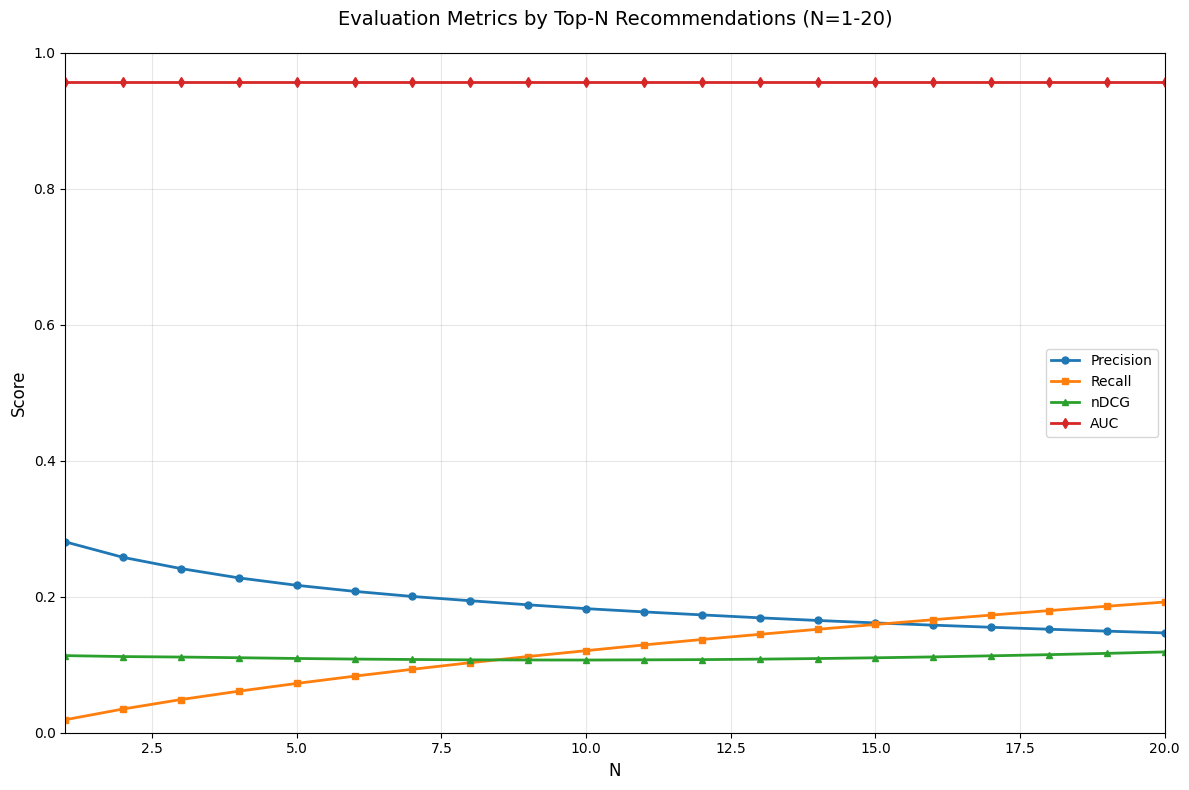

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('metrics_at_k.csv')

# Define plot style and settings
plt.figure(figsize=(12, 8))

# Plot each metric with clear styling
metrics = {
    'precision_at_k': {'label': 'Precision', 'marker': 'o', 'color': '#1f77b4'},
    'recall_at_k': {'label': 'Recall', 'marker': 's', 'color': '#ff7f0e'},
    'ndcg_at_k': {'label': 'nDCG', 'marker': '^', 'color': '#2ca02c'},
    'auc': {'label': 'AUC', 'marker': 'd', 'color': '#d62728'},
}

for metric, props in metrics.items():
    plt.plot(
        df['k'],
        df[metric],
        label=props['label'],
        marker=props['marker'],
        color=props['color'],
        linewidth=2,
        markersize=5
    )

# Customize plot
plt.title('Evaluation Metrics by Top-N Recommendations (N=1-20)', fontsize=14, pad=20)
plt.xlabel('N', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.xlim(1, 20)
plt.ylim(0, 1.0)
plt.grid(True, alpha=0.3)
plt.legend(loc='center right')
plt.tight_layout()

# Show plot
plt.show()
